In [358]:
from clearml import Task, TaskTypes, Dataset
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import ppscore as pps
import matplotlib.pyplot as plt

In [359]:
import warnings
warnings.filterwarnings('ignore')

In [360]:
def fix_cardinality(merged_no_dup, column, new_value ,in_freq = 30, ):
    value_counts = merged_no_dup[column].value_counts()
    higher_freq_values = []

    freq_dict = dict(value_counts)
    for value, freq in freq_dict.items():
        if freq < in_freq:
            merged_no_dup.loc[merged_no_dup[column] == value, column] = new_value 
        else:
            higher_freq_values.append(value)
    print(set(higher_freq_values))
    return merged_no_dup

In [361]:
data = pd.read_excel('data/curated_claims_denial.xlsx')#'data/Claim Denial Updated V7.csv')
data.shape

(2845, 68)

In [362]:
'COUNTYX' in data['COUNTY'].tolist()

False

In [363]:
columns_to_remove = ['Unnamed: 0' ,'CLAIM_TYPE', 'CLAIM_ID' , 'CLAIM_LINE_NUMBER', 'ENCOUNTER_ID', 'PATIENT_ID', 'Name',
'CLAIM_END_DATE', 'CLAIM_LINE_START_DATE','CLAIM_LINE_END_DATE',
'PLACE_OF_SERVICE_DESCRIPTION','REVENUE_CENTER_DESCRIPTION','RENDERING_NPI',
'FACILITY_NPI','DISCHARGE_DISPOSITION_DESCRIPTION','DATA_SOURCE','PAYER', 'PAYER_TYPE', 'BIRTH_DATE','ZIP_CODE','DECEASED_FLAG',
'CONDITION_DATE','CONDITION_TYPE','CODE_TYPE','DESCRIPTION','MONTH','YEAR','ENCOUNTER_START_DATE',
'ENCOUNTER_END_DATE','ADMIT_SOURCE_DESCRIPTION','ADMIT_TYPE_DESCRIPTION',
'Year','PHYSICIAN_NPI', 'DENIAL_CATEGORY','APPROVED_CHARGE','CLAIM_STATUS', 'REASON_CODE_DESCRIPTION','DIAG_GENDER_MISMATCH','DIAG_AGE_MISMATCH','DIFF_PROC_DT_COV_ST_DT','DIFF_PROC_DT_COV_ED_DT'] 
#,'COVERAGE_START_DATE','COVERAGE_END_DATE','CLAIM_START_DATE','PROCEDURE_DATE'
print(len(columns_to_remove))

41


In [364]:
dat_cols = [col for col in data.columns if 'DATE' in col]
for col in dat_cols:
    data[col] = data[col].astype('datetime64[ns]')

In [365]:
# 18	Expenses incurred prior to coverage. PROCEDURE_DATE < COVERAGE_START_DATE
for i in range(len(data)):
    data.loc[i,'PROC_COVER_START_DIFF'] = (data.loc[i, "PROCEDURE_DATE"] - data.loc[i, "COVERAGE_START_DATE"]).days
for i in range(len(data)):
    data.loc[i,'PROC_COVER_START_MISMATCH'] = data.loc[i, "PROCEDURE_DATE"] < data.loc[i, "COVERAGE_START_DATE"]

data.shape

(2845, 70)

In [366]:
#### 19	Expenses incurred after coverage terminated. PROCEDURE_DATE > COVERAGE_END_DATE
for i in range(len(data)):
    data.loc[i,'PROC_COVER_END_DIFF'] = (data.loc[i, "PROCEDURE_DATE"] - data.loc[i, "COVERAGE_END_DATE"]).days
    
for i in range(len(data)):
    data.loc[i,'PROC_COVER_END_MISMATCH'] = data.loc[i, "PROCEDURE_DATE"] < data.loc[i, "COVERAGE_START_DATE"]
data.shape

(2845, 72)

In [367]:
# 10	The diagnosis is inconsistent with the patient's gender.*
filtered = data[data['REASON_CODE'] == 10.0]
codes = filtered['CODE'].unique()
for i in range(len(data)):
    if  data.loc[i, "GENDER"] == 'female' and  data.loc[i, "CODE"] in codes:
        data.loc[i, 'CODE_AGE_MISMATCH'] = True
    else:
        data.loc[i, 'CODE_AGE_MISMATCH'] = False
data.shape

(2845, 73)

In [368]:
# 9	The diagnosis is inconsistent with the patient's age. 
filtered = data[data['REASON_CODE'] == 9.0]
codes = filtered['CODE'].unique()
for i in range(len(data)):
    if  data.loc[i, "Age"] < 20 and  data.loc[i, "CODE"] in codes:
        if  data.loc[i, "GENDER"] == 'female' and  data.loc[i, "CODE"] in codes:
            data.loc[i, 'CODE_GENDER_MISMATCH'] = True
        else:
            data.loc[i, 'CODE_GENDER_MISMATCH'] = False
data.shape

(2845, 74)

In [369]:
col_removed_df = data.drop(columns_to_remove, axis=1)
col_removed_df.shape

(2845, 33)

In [370]:
col_removed_df['REASON_CODE'].value_counts()

1     2725
18      30
19      30
10      30
9       30
Name: REASON_CODE, dtype: int64

In [371]:
norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY', 'PROC_COVER_START_DIFF','PROC_COVER_END_DIFF']
#norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY']

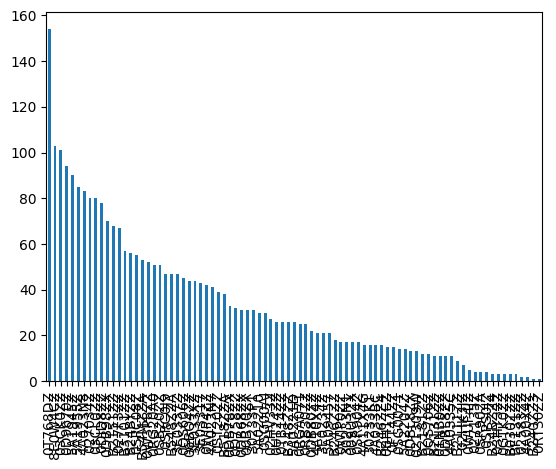

In [372]:
col_removed_df['PROCEDURE_CODE'].value_counts().plot(kind='bar')
plt.show()

In [373]:
col_removed_df = fix_cardinality(col_removed_df,column='STATE', in_freq=50, new_value="STATE_X")

{'Tennessee', 'Oregon', 'New Jersey', 'Iowa', 'Michigan', 'Texas', 'New York', 'Mississippi', 'North Carolina', 'Wisconsin', 'Pennsylvania', 'Washington', 'Oklahoma', 'South Carolina', 'Florida', 'Indiana', 'Ohio', 'California', 'Illinois', 'Minnesota', 'Massachusetts', 'Nebraska', 'Georgia'}


In [374]:
col_removed_df = fix_cardinality(col_removed_df,column='HCPCS_CODE', in_freq=15, new_value='G8979')
col_removed_df = fix_cardinality(col_removed_df,column='COUNTY', in_freq=30, new_value='COUNTY_X')
col_removed_df = fix_cardinality(col_removed_df,column='CODE', in_freq=90, new_value="CODE_X")
col_removed_df = fix_cardinality(col_removed_df,column='REVENUE_CENTER_CODE', in_freq=50, new_value="REVENUE_CENTER_CODE_X")
col_removed_df = fix_cardinality(col_removed_df,column='PROCEDURE_CODE', in_freq=50, new_value="PROCEDURE_CODEX")
col_removed_df = fix_cardinality(col_removed_df,column='STATE', in_freq=50, new_value="STATE_X")
col_removed_df.shape

{87040, 82306, 84484, 71048, 97164, 83735, 85018, 'Q0510', 99100, 85025, 'P2028', 'Q9967', 85027, 'G0378', 93229, 80048, 80053, 80061, 36415, 'A4206', 'Z7512', 93005, 'A9270', 99284, 97110, 84439, 84443, 83036, 'J7030', 93798, 96360, 81001, 85610, 81003, 88299, 'G0463', 97140, 82550, 97530, 'J3010'}
{'Butler', 'Bailey', 'La Porte', 'Palm Beach', 'Smith', 'Knox', 'Pottawattamie', 'Wichita', 'Clatsop', 'Warrick', 'Cleveland', 'San Francisco', 'Cumberland', 'Washington', 'Middlesex', 'Delaware', 'Door', 'Madison', 'Los Angeles', 'Ventura', 'Horry', 'Suffolk'}
set()
{420, 300, 301, 272, 305, 730, 250, 636, 637, 510}
{'0W3P8ZZ', '0DB98ZX', '0D9670Z', '0DJD8ZZ', '027034Z', '03CL0ZZ', '5A1955Z', '03CK0ZZ', '0T768DZ', 'B54MZZA', '5A1945Z', '4A023N8', 'B24BYZZ', 'B2151ZZ', '0SPC08Z', '8E0W4CZ', '0RG20A0', '027F3ZZ', 'B3101ZZ', '0SB20ZZ'}
{'Tennessee', 'Oregon', 'New Jersey', 'Iowa', 'Michigan', 'Texas', 'New York', 'Mississippi', 'North Carolina', 'STATE_X', 'Wisconsin', 'Pennsylvania', 'Washin

(2845, 33)

In [375]:
categorcal_cols = [col for col in col_removed_df.columns if 'DATE' not in col and col !='REASON_CODE' and col not in norm_features]
len(categorcal_cols)

23

In [376]:
for col in categorcal_cols:
    print(col, col_removed_df[col].nunique())

BILL_TYPE_CODE 24
PLACE_OF_SERVICE_CODE 5
REVENUE_CENTER_CODE 11
HCPCS_CODE 41
DISCHARGE_DISPOSITION_CODE 10
GENDER 2
RACE 7
STATE 24
COUNTY 23
CODE 1
PRESENT_ON_ADMIT 3
DUAL_STATUS 9
MEDICARE_STATUS 3
ENCOUNTER_TYPE 5
ADMIT_SOURCE_CODE 3
ADMIT_TYPE_CODE 3
MS_DRG 33
PAYERS 6
PROCEDURE_CODE 21
PROC_COVER_START_MISMATCH 2
PROC_COVER_END_MISMATCH 2
CODE_AGE_MISMATCH 2
CODE_GENDER_MISMATCH 2


In [377]:
dumy_encoded = pd.get_dummies(col_removed_df,columns=categorcal_cols,drop_first=True)
dumy_encoded.shape

(2845, 229)

In [378]:
dumy_encoded.to_csv('preprocessed_cat_encoded.csv', index=False)
col_removed_df.to_csv('Preprocessed.csv', index=False)

In [379]:
col_removed_df.columns

Index(['CLAIM_START_DATE', 'BILL_TYPE_CODE', 'PLACE_OF_SERVICE_CODE',
       'REVENUE_CENTER_CODE', 'SERVICE_UNIT_QUANTITY', 'TOTAL_CHARGES',
       'HCPCS_CODE', 'DISCHARGE_DISPOSITION_CODE', 'COVERAGE_START_DATE',
       'COVERAGE_END_DATE', 'GENDER', 'Age', 'RACE', 'STATE', 'COUNTY', 'CODE',
       'PRESENT_ON_ADMIT', 'DUAL_STATUS', 'MEDICARE_STATUS', 'ENCOUNTER_TYPE',
       'ADMIT_SOURCE_CODE', 'ADMIT_TYPE_CODE', 'MS_DRG', 'PROCEDURE_DATE',
       'PAYERS', 'REASON_CODE', 'PROCEDURE_CODE', 'PROC_COVER_START_DIFF',
       'PROC_COVER_START_MISMATCH', 'PROC_COVER_END_DIFF',
       'PROC_COVER_END_MISMATCH', 'CODE_AGE_MISMATCH', 'CODE_GENDER_MISMATCH'],
      dtype='object')

In [380]:
col_removed_df.drop(columns=['REASON_CODE']).head().to_json('input_json_data.json', orient = 'split', compression = 'infer', index = 'true')

In [381]:
col_removed_df.head().to_csv('input_data.csv')

In [382]:
data = {
'CLAIM_START_DATE':0,
'BILL_TYPE_CODE':43025,
'PLACE_OF_SERVICE_CODE':131,
'REVENUE_CENTER_CODE':99,
'SERVICE_UNIT_QUANTITY':'REVENUE_CENTER_CODE_X',
'TOTAL_CHARGES':1,
'HCPCS_CODE':250.42,
'DISCHARGE_DISPOSITION_CODE':'G8979',
'COVERAGE_START_DATE':1,
'COVERAGE_END_DATE':42370,
'GENDER':43344,
'Age':'male',
'RACE':92,
'STATE':'white',
'COUNTY':'STATE_X',
'CODE':'COUNTY_X',
'PRESENT_ON_ADMIT':'CODE_X',
'DUAL_STATUS':0,
'MEDICARE_STATUS':2,
'ENCOUNTER_TYPE':10,
'ADMIT_SOURCE_CODE':'Other',
'ADMIT_TYPE_CODE':4,
'MS_DRG':3,
'PROCEDURE_DATE':378,
'PAYERS':42293,
'REASON_CODE':'Cigna',
'PROCEDURE_CODE':18
}